# Set Up


In [1]:
%load_ext autoreload
%autoreload 2
from google.colab import drive
drive.mount('/content/drive')

ModuleNotFoundError: No module named 'google.colab'

In [2]:
import os
GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = '社群媒體分析/Study_Group1' # The folder path that contain this ipynb
GOOGLE_DRIVE_PATH               = os.path.join('drive','My Drive',GOOGLE_DRIVE_PATH_AFTER_MYDRIVE)
print(os.listdir(GOOGLE_DRIVE_PATH))

FileNotFoundError: [WinError 3] 系統找不到指定的路徑。: 'drive\\My Drive\\社群媒體分析/Study_Group1'

In [3]:
import pandas
import jieba
import jieba.analyse
import pandas as pd
import re
import matplotlib
import plotly.express as px
from wordcloud import WordCloud
import matplotlib.pyplot as plt

In [4]:
# 設定圖的字體
plt.rcParams['font.size'] = 14
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False
matplotlib.font_manager.fontManager.addfont(GOOGLE_DRIVE_PATH+'/SourceHanSansTW-Regular.otf')
matplotlib.rc('font', family='Source Han Sans TW')

AttributeError: 'FontManager' object has no attribute 'addfont'

# 概述

<br>

#### 「龍龍」和「老K」，兩位脫口秀演員日前在節目「炎上」演出時發生不愉快，而因為整個事件牽扯了許多網紅包括「博恩」、「呱吉」、「雞排妹」，因此也成為當時吃瓜群眾津津樂道的話題。我們想要透過分析PTT上的發文來了解網民對於整件事的看法。分為以下為2大方向

<br>

#### 1. 對整體資料做**情緒分析**、顯示**文章數量**，**找出情緒轉折點**
#### 2. 將時間段**切成5小段**，利用**文字雲**觀察不同**網紅發言後對於輿論的影響**


# 資料


## 匯入資料

In [186]:
MetaData = pd.read_csv(GOOGLE_DRIVE_PATH+'/data/oldk_article_adjusted_time.csv', encoding='UTF-8')
Reviews = pd.read_csv(GOOGLE_DRIVE_PATH+'/data/oldk_review_adjusted_time.csv', encoding='UTF-8')
print(f"共有 {MetaData.shape[0]} 篇文章")
print(f"共有 {Reviews.shape[0]} 個留言")

共有 1456 篇文章
共有 73313 個留言


## 資料結構

In [6]:
MetaData.head(3)

artTitle  ...                                           sentence
0      [問卦]看到電視劇有電話號碼就想打的是什麼人？  ...  魷魚遊戲爆紅 名片電話號碼也爆\r\n\r\n想起以前有不少電視劇或節目上露出的電話號碼都有...
1       [新聞]網紅議員聲援陳柏惟台語質詢　反遭網嗆  ...  https://news.tvbs.com.tw/politics/1594417\r\n網...
2  Re:[新聞]基隆捷運喊30年還沒蓋！交通部：一個月內  ...  基隆根本沒什麼發展性\r\n\r\n路又小 平地又少 九成都沒開發的價值\r\nhttps:...

[3 rows x 10 columns]

In [ ]:
Reviews.head(3)

artTitle     artDate  ...              cmtDate cmtContent
0  [問卦]看到電視劇有電話號碼就想打的是什麼人？  2021-09-29  ...  2021-09-29 09:52:00   :叫人家起床尿尿
1  [問卦]看到電視劇有電話號碼就想打的是什麼人？  2021-09-29  ...  2021-09-29 09:52:00   :7533967
2  [問卦]看到電視劇有電話號碼就想打的是什麼人？  2021-09-29  ...  2021-09-29 09:57:00       :智障啊

[3 rows x 10 columns]

# 資料清理
<br>

### 1.所有的資料都是以**GMT+0時區**, 我們先行將資料調整成**GMT+8時區**，以進行更細節的分析
### (匯入的資料是已經調整時差後的時間)


In [187]:
## MetaData DateTime
MetaData['cmtDate'] = MetaData.artDate+' '+MetaData.artTime
MetaData['cmtDate'] = pd.to_datetime(MetaData.cmtDate)

## Review DateTime
Reviews['cmtDate'] = pd.to_datetime(Reviews.cmtDate)

### 2.去除NA值


In [188]:
Reviews.dropna(subset = ["cmtContent"], inplace=True)

### 3.去除特殊字元留下漢字

In [189]:
# 去除特殊字元與標點符號
# 去除html特殊字元編碼
def clean(row):
    try:
      text = re.sub("[\t]{2,}", "", row)              # 去除兩個以上空格或tab
      text = re.sub("(http|https)://.*", "", text)    # 去除網址(".":任意字元, "*":0次以上)
      text = re.sub("&.*;", "", text)                 # 去除html特殊字元編碼
      text = re.sub("<\w\+\w{4,}>", "", text)         # 去除阿拉伯數字
      text = re.sub("#_*", "", text)                  # 去除一個或多個_
      text = re.sub("\\n", " ", text)                 # 去除換行
      text = re.sub("\s{2,}", " ", text)              # 去除多個空格
      text = re.sub("^\\s+|\\s+$", "", text)          # 去除開頭/結尾有一個或多個空格(+:一次以上)
      text = re.sub("k", "K", text)                   # 把小寫k都換成大寫K
      text = re.sub('[^a-zA-Z\u4e00-\u9fa5]+', '', text)
    except:
      return ''
    return text

In [190]:
keywords = ['龍龍','老K','博恩','雞排妹','薩泰爾','炎上','切割','馬謖']
toMatch = '|'.join(keywords)

MetaData = MetaData.loc[MetaData['sentence'].str.contains(toMatch) | MetaData['artTitle'].str.contains(toMatch), :]
MetaData.reset_index(inplace=True, drop=True) #重設index

Reviews = Reviews.loc[Reviews['cmtContent'].str.contains(toMatch) | Reviews['cmtContent'].str.contains(toMatch), :]
Reviews.reset_index(inplace=True, drop=True) #重設index

In [191]:
Reviews['cmtContent'] = Reviews.cmtContent.apply(clean)
Reviews = Reviews[Reviews.cmtContent != '']
Reviews['cmtContent']

0          博恩打給韓導那個是早就SET好的
1         搞清楚韓國瑜是付錢去給博恩笑的好嗎
2       雖然覺得龍龍的梗沒特別中我的點但老K寫
3         龍龍自己不也是愛開這種梗的玩笑現在
4         龍龍去掉顏色梗就更沒有特色了雖然她
               ...         
7445     話但是老K在台上說出來的不是這個版本
7446            而龍龍終於承認她記錯了
7447     你搞錯了老K脫稿演出在事後已經被懲處
7448    而老K被留停原因其實是在老男孩上的發言
7449     有可能嚴重打擊薩泰爾是故在後來評估影
Name: cmtContent, Length: 7450, dtype: object

In [192]:
MetaData['sentence'] = MetaData.sentence.apply(clean)
MetaData = MetaData[MetaData.sentence != '']
MetaData['sentence']

0       魷魚遊戲爆紅名片電話號碼也爆想起以前有不少電視劇或節目上露出的電話號碼都有被騷擾的新聞到底是...
1       基隆根本沒什麼發展性路又小平地又少九成都沒開發的價值拉一條捷運到底要幹嘛北部唯一可行的就桃園...
2       博恩在笑韓國瑜的時候有得到韓國瑜的同意嗎黃逸豪在笑護家盟的時候有得到護加盟的同意嗎那為什麼老...
3             所以博恩到底好不好笑啊我最近覺得ryanlong超好笑的他最近要來奧斯丁我該買票去看嗎
4       剛看專訪影片龍龍是認為她幾年前就私下跟老K講過而老K也同意不再講她跟賀龍的事情但是這幾年又開...
                              ...                        
1381    千萬不要意圖去惹女人女人的標準不是標準女人無法被量化這是一種防衛駕駛的概念不碰她今天還是天下...
1382    遭雞排妹點名對不起龍龍百靈果凱莉委曲爆哭到底甘我屁事出版時間更新時間凱莉右圖翻攝凱莉臉書對於...
1383    安安小弟剛剛跟前女友說龍龍的事她問我是誰想說鬧這麼大怎麼只有我知道是不是pttdcard太小...
1384    我一直不太明白儘管龍龍再怎麼雙標好戰操弄輿論無限上綱她個人的基本訴求在我看來一直都蠻明確的不...
1385    小魯剛剛去看嚕最近很紅的龍好像沒幾片啃得下去真的跟黃豪平說的一樣要當A片看一直快轉怎麼會有人...
Name: sentence, Length: 1386, dtype: object

### 4. jieba 斷詞

#### 斷詞&文字雲物件

In [193]:
class jieba_word_cloud():

  def __init__(self,GOOGLE_DRIVE_PATH,user_stop=None):
    normal_path = ['/dict/dict.txt','/dict/user_dict.txt','/dict/stopwords.txt','/SourceHanSansTW-Regular.otf']

    if GOOGLE_DRIVE_PATH:
      normal_path = [GOOGLE_DRIVE_PATH+i for i in normal_path]
    else :
      normal_path = ['.'+i for i in normal_path]

    self.jieba_path = normal_path[0]
    self.user_dict  = normal_path[1]
    self.stopword   = normal_path[2]
    self.font_path  = normal_path[3]

    jieba.set_dictionary(self.jieba_path)

    with open(self.user_dict,encoding="utf-8") as f:
      user_dict = [line.strip() for line in f.readlines()]

    for word in user_dict:
      jieba.add_word(word, freq=None, tag=None)

    self.jieba = jieba

    

    with open(self.stopword,'r') as f:
      self.stopwords = f.read().splitlines()

    if user_stop:
      for i in user_stop:
        self.stopwords.append(i)

  def word_clean(self,text):
    
    
    doc_tokens = self.jieba.lcut(text)

    doc_tokens = list(filter(lambda x : (x not in self.stopwords) & (len(x)>=2), doc_tokens))

    
    return doc_tokens

  def df_to_cloud(self,df,date=['2021-10-01','2021-10-01'],limit = [10,450],font_path=None,max_words=200):
    font_path = self.font_path if font_path is None else font_path

    word_count = df.groupby(['artDate','word'],as_index=False).size()
    cloud_data = self.Wc_dict(word_count,date[1],date[0],limit[1],limit[0])
    wordcloud = WordCloud(background_color='white',width=800, height = 400, font_path=font_path, max_words=max_words)
    wordcloud.generate_from_frequencies(cloud_data)
    plt.figure(figsize = (14,7))
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.show()

  def Wc_dict(self,df, DateB,DateS, countB, countS):
    wc_df = (df.query('artDate >= @DateS') # 篩選日期
             .query('artDate <= @DateB') # 篩選日期
             .query('size < @countB')# 篩選最大數量
             .query('size > @countS')# 篩選最小數量
             .sort_values('size', ascending=False))
    wc_dict = dict(zip(wc_df['word'], wc_df['size'])) #建立成dictionary
    
    return wc_dict
    

In [194]:
process = jieba_word_cloud(GOOGLE_DRIVE_PATH)

Building prefix dict from /content/drive/My Drive/社群媒體分析/Study_Group1/dict/dict.txt ...
Loading model from cache /tmp/jieba.u0c258b2435c50277f01f6a2df825d413.cache
Loading model cost 0.631 seconds.
Prefix dict has been built successfully.


#### 字詞切分

In [195]:
#文章內容斷詞
MetaData['word'] = MetaData.sentence.apply(process.word_clean)
# 將word欄位展開
MetaData_token = MetaData.explode('word') 
MetaData_token.head(3)

artTitle     artDate  ...             cmtDate word
0  [問卦]看到電視劇有電話號碼就想打的是什麼人？  2021-09-29  ... 2021-09-29 09:51:24   魷魚
0  [問卦]看到電視劇有電話號碼就想打的是什麼人？  2021-09-29  ... 2021-09-29 09:51:24   遊戲
0  [問卦]看到電視劇有電話號碼就想打的是什麼人？  2021-09-29  ... 2021-09-29 09:51:24   爆紅

[3 rows x 12 columns]

In [196]:
#留言內容斷詞
Reviews['word'] = Reviews.cmtContent.apply(process.word_clean)
# 將word欄位展開
Reviews_token = Reviews.explode('word') 
Reviews_token.head(3)

artTitle     artDate  ...        cmtContent word
0  [問卦]看到電視劇有電話號碼就想打的是什麼人？  2021-09-29  ...  博恩打給韓導那個是早就SET好的   博恩
0  [問卦]看到電視劇有電話號碼就想打的是什麼人？  2021-09-29  ...  博恩打給韓導那個是早就SET好的   打給
0  [問卦]看到電視劇有電話號碼就想打的是什麼人？  2021-09-29  ...  博恩打給韓導那個是早就SET好的   韓導

[3 rows x 11 columns]

In [216]:
# 合併斷詞後的本文與留言
data = pd.concat([MetaData_token.loc[:,["artDate","artUrl","word"]],Reviews_token.loc[:,["artDate","artUrl","word"]]],axis=0)
data.head()

artDate                                             artUrl word
0  2021-09-29  https://www.ptt.cc/bbs/Gossiping/M.1632880286....   魷魚
0  2021-09-29  https://www.ptt.cc/bbs/Gossiping/M.1632880286....   遊戲
0  2021-09-29  https://www.ptt.cc/bbs/Gossiping/M.1632880286....   爆紅
0  2021-09-29  https://www.ptt.cc/bbs/Gossiping/M.1632880286....   名片
0  2021-09-29  https://www.ptt.cc/bbs/Gossiping/M.1632880286....   電話

In [217]:
#計算每天不同字的詞頻
word_count = data.groupby(['artDate','word'],as_index=False).size()
word_count.sort_values(by=['size'], ascending=False,inplace=True)  #排序
word_count = word_count[word_count['size']>3]  #過濾出現太少次的字
word_count.head(10)

artDate word  size
6853   2021-10-02   老K  1532
8479   2021-10-02   龍龍  1305
13942  2021-10-03   老K  1149
15853  2021-10-03   龍龍   974
3592   2021-10-02   博恩   832
10030  2021-10-03   博恩   745
26899  2021-10-07   龍龍   708
25719  2021-10-07   老K   533
7872   2021-10-02   道歉   366
23207  2021-10-07   博恩   308

# lexicon-base情緒分析


### 1.使用NTUSD字典(分為「正向」、「負向」情緒)

In [199]:
filepath = ['negative','positive']
d_ntusd = []
for file in filepath:
    filename = GOOGLE_DRIVE_PATH + f"/dict/NTUSD/{file}.txt"
    with open(filename, 'r', encoding='UTF-8-sig') as f:
        d_ntusd.append([f.read().split("\n"),file])

df_ntusd = pd.DataFrame(d_ntusd,columns = ['word','sentiments']).explode('word',ignore_index = True)
df_ntusd.head(10)

word sentiments
0          幹   negative
1      一下子爆發   negative
2  一下子爆發的一連串   negative
3        一巴掌   negative
4         一再   negative
5       一再叮囑   negative
6         一拳   negative
7      一般殺人罪   negative
8       一陣狂風   negative
9       一陣緊張   negative

In [200]:
prop_df = df_ntusd.groupby(['sentiments']).count().reset_index()
px.pie(prop_df,values='word',names='sentiments', title='NTUSD字典中正向(紅色) vs 負向(藍色) 比例')

In [201]:
#文章和與NTUSD情緒字典做合併
data_ntusd = pd.merge(data, df_ntusd, on=['word'],how='left')

#算出每天情緒總和(sentiment_count)
sentiment_count = data_ntusd.groupby(['artDate','sentiments'],as_index=False).size()
sentiment_count.head()

sentiment_count_r = sentiment_count.assign(ratio = sentiment_count.groupby(['artDate'], as_index=False)
                                           .apply(lambda x: x['size'] / sum(x['size'])).reset_index(level=0, drop=True))

### 每日發文狀況

#### 將情緒字典與斷詞結果進行合併。大約在9/30之後才比較有討論的聲量，10/2達到第一高聲量之後便開始下降。到10/5又漸漸有討論度，10/7討論度達到第二高聲量後便下降。

In [202]:
data_datecount = pd.DataFrame(MetaData.groupby('artDate').size(),columns = ['count']).reset_index()
px.line(data_datecount,x='artDate',y='count',title='每日發文數量',hover_data=['count'])

In [169]:
px.line(sentiment_count_r,x='artDate',y='size',color='sentiments',title='正負情緒分數折線圖')

In [170]:
px.line(sentiment_count_r,x='artDate',y='ratio',color='sentiments',title='正負情緒比例折線圖')

### 1.使用LIWC字典(分為「正向」、「負向」情緒)

In [171]:
filepath = ['negative','positive']
d_liwc = []
for file in filepath:
    filename = GOOGLE_DRIVE_PATH + f"/dict/LIWC/{file}.txt"
    with open(filename, 'r', encoding='UTF-8-sig') as f:
        d_liwc.append([f.read().split(","),file])

df_liwc = pd.DataFrame(d_liwc,columns = ['word','sentiments']).explode('word',ignore_index = True)
df_liwc.head(10)

word sentiments
0  一無所有   negative
1  七竅生煙   negative
2    上當   negative
3    下流   negative
4    下等   negative
5    不仁   negative
6    不便   negative
7   不公平   negative
8    不准   negative
9    不利   negative

In [172]:
prop_df = df_liwc.groupby(['sentiments']).count().reset_index()
px.pie(prop_df,values='word',names='sentiments', title='LIWC字典裡正向(紅色) vs 負向(藍色) 比例')

In [173]:
#文章和與LIWC情緒字典做合併
data_liwc = pd.merge(data, df_liwc, on=['word'],how='left')

#算出每天情緒總和(sentiment_count)
sentiment_count = data_liwc.groupby(['artDate','sentiments'],as_index=False).size()
sentiment_count.head()

sentiment_count_r = sentiment_count.assign(ratio = sentiment_count.groupby(['artDate'], as_index=False)
                                           .apply(lambda x: x['size'] / sum(x['size'])).reset_index(level=0, drop=True))

In [174]:
px.line(sentiment_count_r,x='artDate',y='size',color='sentiments',title='正負情緒分數折線圖')

In [107]:
px.line(sentiment_count_r,x='artDate',y='ratio',color='sentiments',title='正負情緒比例折線圖')

# 網紅發言對輿論影響

In [203]:
import plotly.express as px
import plotly.graph_objects as go
datecount =  MetaData.copy()
datecount['ByHour'] = pd.to_datetime(datecount['artDate']+' '+[i[0:2] for i in datecount['artTime']])

datecount =  pd.DataFrame(datecount.groupby(['ByHour']).size(),columns = ['count']).reset_index()

fig = px.line(datecount,x='ByHour',y='count')

time_l = ['2021-09-30 21:00:00','2021-10-2 08:00:00','2021-10-2 19:30:00','2021-10-3 08:00:00','2021-10-7 08:00:00','2021-10-7 21:30:00']
for t in time_l:
  fig.add_shape(type='line',
                  x0=t,
                  y0=0,
                  x1=t,
                  y1=90,
                  line=dict(color='Red',),
                  xref='x',
                  yref='y'
  )


fig.add_trace(go.Scatter(
    x=time_l,
    y=[95,105,100]*(len(time_l)//2),
    text=["9/30 呱吉引火上身",
          "10/2 博恩回應",
          "10/2 老K回應",
          "10/3 龍龍被PTT抓小辮子",
          "10/6 龍龍淚崩11分鐘",
          "10/7 雞排妹屠龍"],
    mode="text",
    textfont = {'size' : 15}
))

fig

### 呱吉引火上身引火上身(09/30~10/01)


#### 9/30
#### 龍龍在受訪時表達炎上脫稿演出和於直播繼續調侃算是霸凌。<br>文字雲中看出「龍龍」、「博恩」、「脫口秀」等較明顯。

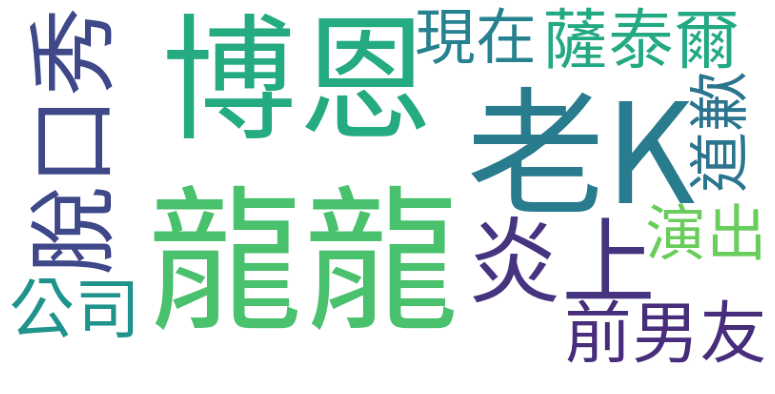

In [204]:
process.df_to_cloud(data,['2021-09-30','2021-09-30'],[10,1000])

#### 10/01

#### 除了與事件有關的人事很明顯以外，還可看到「呱吉」出現且明顯，是因為9/30呱吉直播「火烤呱吉」中提及龍龍不好相處，引火上身，真的變火烤呱吉。

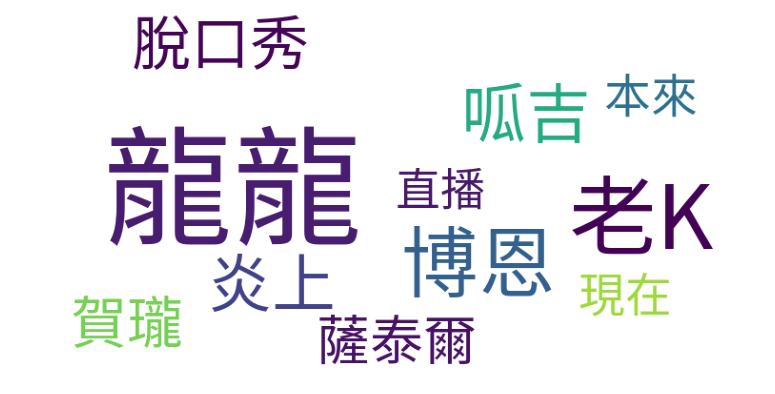

In [205]:
process.df_to_cloud(data,['2021-10-01','2021-10-01'],[20,1000])

#### 從情緒分析來看，此時與論主要還是以正向佔大宗，負面評論中已經有如「雙標」、「問題」、「扭曲」等字眼出現。

In [206]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots


sentiment_date_sum = (word_count.merge(df_liwc, on='word')
                 .groupby(['artDate', 'word', 'sentiments'], as_index=False)
                 .agg({'size': 'sum'}))

#篩選日期
sentiment_0930_1001 = sentiment_date_sum[(sentiment_date_sum['artDate']>="2021-09-30")&(sentiment_date_sum['artDate']=="2021-10-01")].sort_values(by=['sentiments','size'], ascending=[True,False])
b = sentiment_0930_1001.size.max() * 0.05
sentiment_0930_1001 = sentiment_0930_1001.query('size >= @b')


bar = px.bar(sentiment_0930_1001,y = 'size',x = 'word',color='sentiments',orientation='v',title='09/30正向&負向情緒總數')
bar.show()


### 博恩老K回應(10/02)

#### 博恩首度針對龍龍事件拍影片回應，影片中針對整件事件進行說明，其中更公開雙方來往訊息，表示公司立場。最後博恩淚灑於影片中，宣布「老K即日起無限期留職停薪。」博恩發布影片後，老K也首度針對事件進行回應，表示「向所有感到不適的女性男性致上最深的歉意，私人恩怨帶給大家麻煩，真的很抱歉。」，但老K表示並不會向龍龍道歉，也在晚間個人影片中表示，龍龍透過事件操作網路聲量與風向，導致社會有不良的社會觀感。

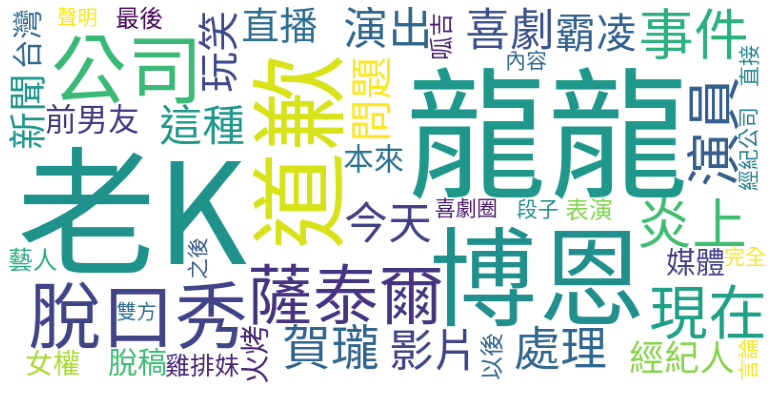

In [207]:
process.df_to_cloud(MetaData_token,['2021-10-02','2021-10-02'],[30,1000])

#### 情緒詞頻中可以發現負面情緒開始增大，老K臨場發揮得「違約」表現成為鄉民們聊天的重點，並且也有人關注在博恩是否「開除」老K。

In [218]:
sentiment_1002 = sentiment_date_sum[sentiment_date_sum['artDate']=="2021-10-02"].sort_values(by=['sentiments','size'], ascending=[True,False])

b = sentiment_1002.size.max() * 0.05
sentiment_1002 = sentiment_1002.query('size >= @b')

bar = px.bar(sentiment_1002,y = 'size',x = 'word',color='sentiments',orientation='v',title='10/02正向&負向情緒總數')
bar.show()


### 龍龍被抓小辮子(10/03~10/05)
#### 龍龍在Instagram公開一名髮型設計師批評他的私訊對話，內容包含對方的個人資訊，隨後引發大量網友至該名設計師與其公司的帳號留言批評，引發龍龍「霸臨」他人的嫌疑。然而同時龍龍也被PTT網友翻出許多以前嘲諷「客家人」、「男生」的表演內容製成梗圖或影片。激起網民討論龍龍作為「脫口秀表演者」可以拿「段子」嘲諷別人，卻不能被嘲諷的「雙標」。

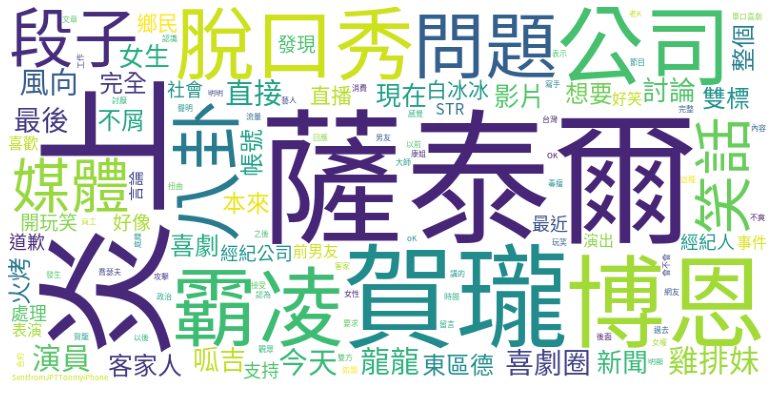

In [219]:
process.df_to_cloud(MetaData_token,['2021-10-03','2021-10-05'],[20,1000])

#### 這邊可以看到「雙標」的詞彙頻率慢慢上升，並且負面情緒的詞彙種類開始變多

In [223]:
sentiment_1003_1005 = sentiment_date_sum[(sentiment_date_sum['artDate']>="2021-10-03")& (sentiment_date_sum['artDate']<="2021-10-05")].sort_values(by=['sentiments','size'], ascending=[True,False])
b = sentiment_1003_1005.size.max() * 0.03
sentiment_1003_1005 = sentiment_1003_1005.query('size >= @b')

bar = px.bar(sentiment_1003_1005,y = 'size',x = 'word',color='sentiments',orientation='v',title='10/03~10/05正向&負向情緒總數')
bar.show()

### 龍龍哭哭11分鐘(10/06)

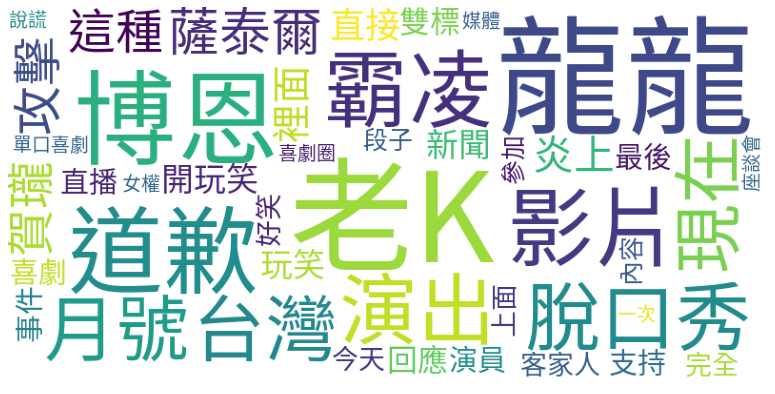

In [224]:
process.df_to_cloud(MetaData_token,['2021-10-06','2021-10-06'],[5,1000])

#### 10/06討論度不高，情緒詞彙的頻率也不會超過10。

In [234]:
sentiment_1006 = sentiment_date_sum[(sentiment_date_sum['artDate']=="2021-10-06")].sort_values(by=['sentiments','size'], ascending=[True,False])
b = sentiment_1006.size.max() * 0.03
sentiment_1006 = sentiment_1006.query('size >= @b')

bar = px.bar(sentiment_1006,y = 'size',x = 'word',color='sentiments',orientation='v',title='10/06正向&負向情緒總數')
bar.show()

### 雞排妹屠龍(10/07)

#### 雞排妹早上早上7:00 FB 貼文律師函，並宣告將會進行屠龍，並在晚間並在晚間8:00左右開直播，拿出次元切割刀切割關係。

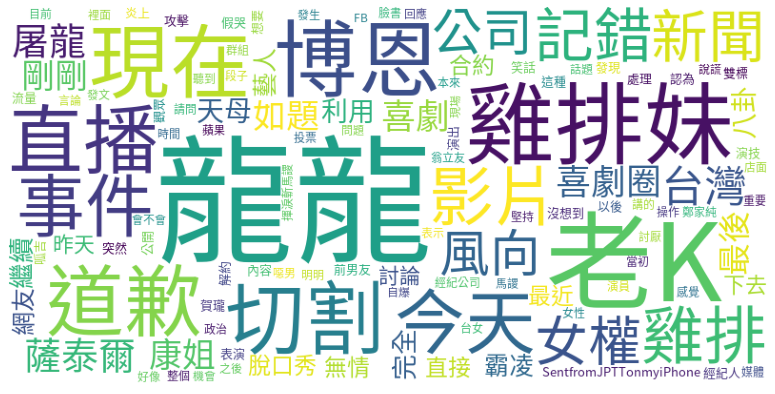

In [226]:
process.df_to_cloud(MetaData_token,['2021-10-07','2021-10-08'],[10,10000])

#### 雞排妹作為經紀公司方，開直播重申自己也是被龍龍欺騙，「無情」切割的行為讓網友紛紛表示「笑死」，難得的正向情緒站上風，網友似乎一掃過去幾天負片情緒。

In [233]:
sentiment_1007_1008 = sentiment_date_sum[(sentiment_date_sum['artDate']>="2021-10-07")&(sentiment_date_sum['artDate']<="2021-10-08")].sort_values(by=['sentiments','size'], ascending=[True,False])
b = sentiment_1007_1008.size.max() * 0.03
sentiment_1007_1008 = sentiment_1007_1008.query('size >= @b')

bar = px.bar(sentiment_1007_1008,y = 'size',x = 'word',color='sentiments',orientation='v',title='10/07~10/08正向&負向情緒總數')
bar.show()

# who is media framing ? 

### 本檔案將以 龍k 事件為主軸，探討哪些 PTT 的用戶可能是引導事件風向的人，主要的方式我們將針對事件期間以及 PTT 用戶的發文與回文頻率先找出不同事件時間點潛在的事件風向引導者，接著再透過文字雲、情緒分析等技巧來進一步探討這些人的站邊立場。

In [5]:
import pandas as pd
import plotly
import numpy as np
import matplotlib.pyplot as plt 
import matplotlib
import re
import jieba
import jieba.analyse
import matplotlib.pyplot as plt
import plotly.express as px
from datetime import datetime
from wordcloud import WordCloud 

## 1. 資料前處理
- 資料來源: 文字平台收集PTT Gossip版2021-09-29 ~ 2021-10-9 所有文章
- 資料集： `oldk_articleMetaData.csv`
- 關鍵字：https://docs.google.com/document/d/1skuDfyf4iRBMpV2P1C98hh8GXJP0-AYKIfj45fy4SHs/edit
- 資料時間：2021-09-29 ~ 2021-10-9 


In [7]:
#匯入資料
MetaData = pd.read_csv('./data/oldk_article_adjusted_time.csv',encoding='UTF-8')
Reviews = pd.read_csv('./data/oldk_review_adjusted_time.csv',encoding='UTF-8')

In [8]:
print(f"共有 {MetaData.shape[0]} 篇文章") #(row,column)
MetaData.head(3)

共有 1456 篇文章


artTitle     artDate   artTime  \
0      [問卦]看到電視劇有電話號碼就想打的是什麼人？  2021-09-29  09:51:24   
1       [新聞]網紅議員聲援陳柏惟台語質詢　反遭網嗆  2021-09-29  12:09:05   
2  Re:[新聞]基隆捷運喊30年還沒蓋！交通部：一個月內  2021-09-30  03:41:33   

                                              artUrl   artPoster     artCat  \
0  https://www.ptt.cc/bbs/Gossiping/M.1632880286....    RackCity  Gossiping   
1  https://www.ptt.cc/bbs/Gossiping/M.1632888547....    benoaico  Gossiping   
2  https://www.ptt.cc/bbs/Gossiping/M.1632944495....  DustToDust  Gossiping   

   commentNum  push  boo                                           sentence  
0           8     3    0  魷魚遊戲爆紅 名片電話號碼也爆\r\n\r\n想起以前有不少電視劇或節目上露出的電話號碼都有...  
1         257    72   69  https://news.tvbs.com.tw/politics/1594417\r\n網...  
2          25     3    0  基隆根本沒什麼發展性\r\n\r\n路又小 平地又少 九成都沒開發的價值\r\nhttps:...

In [9]:
print(f"共有 {Reviews.shape[0]} 個留言")
Reviews.head(3)

共有 73313 個留言


artTitle     artDate   artTime  \
0  [問卦]看到電視劇有電話號碼就想打的是什麼人？  2021-09-29  09:51:24   
1  [問卦]看到電視劇有電話號碼就想打的是什麼人？  2021-09-29  09:51:24   
2  [問卦]看到電視劇有電話號碼就想打的是什麼人？  2021-09-29  09:51:24   

                                              artUrl artPoster     artCat  \
0  https://www.ptt.cc/bbs/Gossiping/M.1632880286....  RackCity  Gossiping   
1  https://www.ptt.cc/bbs/Gossiping/M.1632880286....  RackCity  Gossiping   
2  https://www.ptt.cc/bbs/Gossiping/M.1632880286....  RackCity  Gossiping   

   cmtPoster cmtStatus              cmtDate cmtContent  
0   snow3804         →  2021-09-29 09:52:00   :叫人家起床尿尿  
1  qq0101889         推  2021-09-29 09:52:00   :7533967  
2  michaelwu         →  2021-09-29 09:57:00       :智障啊

In [10]:
# 再篩一次文章
keywords = ['老K','老k','龍','龍K','龍k','家純','賀龍','雞排','薩泰爾','博恩','炎上','LL',
            '喜劇','雞排','家純','阿純','佳純','賀瓏','籠籠','志祺77','康姐','康姊','鬼才阿水',
            '女權','假哭','雙標','馬謖','陳沂','翁']
toMatch = '|'.join(keywords)

In [11]:
#MetaData = MetaData.loc[MetaData['sentence'].str.contains(toMatch) | MetaData['artTitle'].str.contains(toMatch), :]
MetaData = MetaData.loc[MetaData['artTitle'].str.contains(toMatch), :]
MetaData.reset_index(inplace=True, drop=True) #重設index
print(MetaData.shape)

(1234, 10)


In [12]:
# 挑選文章對應的留言 (SQL 中的 letf outer merge)
Reviews = MetaData.iloc[:,0:-1].merge(Reviews.loc[:,["artUrl", "cmtContent"]], how = "left", on = 'artUrl')

In [13]:
print(Reviews.shape)
Reviews.head(3)

(63024, 10)


artTitle     artDate   artTime  \
0  Re:[新聞]「內鬨炎上」｜「博恩也管不住他」  2021-09-30  10:16:12   
1  Re:[新聞]「內鬨炎上」｜「博恩也管不住他」  2021-09-30  10:16:12   
2  Re:[新聞]「內鬨炎上」｜「博恩也管不住他」  2021-09-30  10:16:12   

                                              artUrl artPoster     artCat  \
0  https://www.ptt.cc/bbs/Gossiping/M.1632968174....  bebehome  Gossiping   
1  https://www.ptt.cc/bbs/Gossiping/M.1632968174....  bebehome  Gossiping   
2  https://www.ptt.cc/bbs/Gossiping/M.1632968174....  bebehome  Gossiping   

   commentNum  push  boo      cmtContent  
0         118    35   15  :脫口秀本來就是講笑話賣錢啊  
1         118    35   15              :4  
2         118    35   15    :1不要合作2比別人堅強

In [14]:
# 移除cmtContent為na值的資料
Reviews.dropna(subset = ["cmtContent"], inplace=True)
MetaData.dropna(subset = ["sentence"], inplace=True)

In [15]:
MetaData['sentence'] = MetaData.sentence.apply(lambda x: re.sub('[^\u4e00-\u9fa5]+', '', str(x)))
Reviews['cmtContent'] = Reviews.cmtContent.apply(lambda x: re.sub('[^\u4e00-\u9fa5]+', '', x))

In [16]:
MetaData.head(3)

artTitle     artDate   artTime  \
0  Re:[新聞]「內鬨炎上」｜「博恩也管不住他」  2021-09-30  10:16:12   
1  Re:[新聞]「內鬨炎上」｜「博恩也管不住他」  2021-09-30  11:00:57   
2  Re:[新聞]「內鬨炎上」｜「博恩也管不住他」  2021-09-30  11:10:42   

                                              artUrl  artPoster     artCat  \
0  https://www.ptt.cc/bbs/Gossiping/M.1632968174....   bebehome  Gossiping   
1  https://www.ptt.cc/bbs/Gossiping/M.1632970860....  chunlin05  Gossiping   
2  https://www.ptt.cc/bbs/Gossiping/M.1632971445....  lpbrother  Gossiping   

   commentNum  push  boo                                           sentence  
0         118    35   15  博恩在笑韓國瑜的時候有得到韓國瑜的同意嗎黃逸豪在笑護家盟的時候有得到護加盟的同意嗎那為什麼老...  
1           7     2    0                所以博恩到底好不好笑啊我最近覺得超好笑的他最近要來奧斯丁我該買票去看嗎  
2          19     5    0  剛看專訪影片龍龍是認為她幾年前就私下跟老講過而老也同意不再講她跟賀龍的事情但是這幾年又開始故...

In [17]:
Reviews.head(3)

artTitle     artDate   artTime  \
0  Re:[新聞]「內鬨炎上」｜「博恩也管不住他」  2021-09-30  10:16:12   
1  Re:[新聞]「內鬨炎上」｜「博恩也管不住他」  2021-09-30  10:16:12   
2  Re:[新聞]「內鬨炎上」｜「博恩也管不住他」  2021-09-30  10:16:12   

                                              artUrl artPoster     artCat  \
0  https://www.ptt.cc/bbs/Gossiping/M.1632968174....  bebehome  Gossiping   
1  https://www.ptt.cc/bbs/Gossiping/M.1632968174....  bebehome  Gossiping   
2  https://www.ptt.cc/bbs/Gossiping/M.1632968174....  bebehome  Gossiping   

   commentNum  push  boo     cmtContent  
0         118    35   15  脫口秀本來就是講笑話賣錢啊  
1         118    35   15                 
2         118    35   15      不要合作比別人堅強

### 2.3 找出活躍的用戶 

In [18]:
data_for_count = pd.concat([MetaData.loc[:,["artDate","artTime","artPoster"]],Reviews.loc[:,["artDate","artTime","artPoster"]]],axis=0)
data_for_count['artPoster'].value_counts()

error123       1787
Lalef          1503
jealous0953    1190
punk70286      1171
ororzzz        1129
               ... 
louise13          1
tadshift2         1
datow1002         1
j29980424         1
IPJ               1
Name: artPoster, Length: 761, dtype: int64

In [19]:
poster_count = data_for_count.groupby(['artPoster','artDate']).size().reset_index(name='counts')
poster_count = poster_count.loc[poster_count['counts'] > 100]
poster_count = poster_count.sort_values(by='counts',ascending=False) 
poster_count

artPoster     artDate  counts
534     error123  2021-10-03    1787
679  jealous0953  2021-10-02    1190
878    punk70286  2021-10-02    1171
835      ororzzz  2021-10-06    1129
640      ig49999  2021-10-02     984
..           ...         ...     ...
830   officegirl  2021-10-07     105
405     b1b2b3b4  2021-10-03     105
155     KENDO777  2021-10-03     103
294      VOT1077  2021-10-05     102
724    kobe30418  2021-10-03     102

[143 rows x 3 columns]

In [20]:
import plotly.graph_objects as go

fig = px.bar(poster_count,
             x='artDate',
             y='counts',
             title='Stacked bar chart',
             color='artPoster',
             barmode='stack')

fig.show()

#### 由上圖可以明顯看出確實有部分用戶會在特定的事件時間軸在 PTT 版上進行事件的討論或式風向的引導，為此，我們特地在不同的事件時間點挑選出 count > 900 的用戶進行分析，我們想探討這些用戶所選擇的站邊以及其所使用的言詞。 事件與人物一共分成以下幾點討論 : 
- 10/2 事件: 博恩與老K回應,  分析用戶: jealous0953, punk70286
- 10/3 事件: 龍龍抓小辮子繼續開火,  分析用戶: error123,takizawa5566
- 10/6 事件: 龍龍釋出 11 分鐘淚崩影片, 分析用戶: ororzzz

In [22]:
#設定繁體中文詞庫
jieba.set_dictionary('./dict/dict.txt.big')
#新增自定義字典
jieba.load_userdict('./dict/user_dict.txt')
#新增stop words
#jieba.analyse.set_stop_words('./dict/stop_words.txt') #jieba.analyse.extract_tags才會作用
with open('./dict/stopwords.txt',encoding="utf-8") as f:
    stopWords = [line.strip() for line in f.readlines()]

Building prefix dict from C:\Users\bppas\Desktop\Study_Group1\dict\dict.txt.big ...
Dumping model to file cache C:\Users\bppas\AppData\Local\Temp\jieba.u8c28743d71fa40772486a7bf6edaba64.cache
Loading model cost 1.082 seconds.
Prefix dict has been built successfully.


In [23]:
def getToken(row):
    
    seg_list = jieba.lcut(row) #lcut :以 list 存取結果, cut:以 generator 存取結果。
    seg_list = [w for w in seg_list if w not in stopWords and len(w) > 1] # 篩選不在停用字的字與字元數大於1的字詞
    return seg_list

In [24]:
MetaData['word'] = MetaData.sentence.apply(getToken) #setence.apply(f(x)) 非常好用，可以將 row data 一筆一筆丟入 function 中
Reviews['word'] = Reviews.cmtContent.apply(getToken)

In [25]:
# 將word欄位展開 (將 list 中的字分別獨立成一個個各別的 row)
MetaData_token = MetaData.explode('word') 
Reviews_token = Reviews.explode('word') 

In [26]:
data = pd.concat([MetaData_token.loc[:,["artDate","artTime","artPoster","artUrl","word"]],Reviews_token.loc[:,["artDate","artTime","artPoster","artUrl","word"]]],axis=0)
data.head()

artDate   artTime artPoster  \
0  2021-09-30  10:16:12  bebehome   
0  2021-09-30  10:16:12  bebehome   
0  2021-09-30  10:16:12  bebehome   
0  2021-09-30  10:16:12  bebehome   
0  2021-09-30  10:16:12  bebehome   

                                              artUrl word  
0  https://www.ptt.cc/bbs/Gossiping/M.1632968174....   博恩  
0  https://www.ptt.cc/bbs/Gossiping/M.1632968174....   韓國  
0  https://www.ptt.cc/bbs/Gossiping/M.1632968174....   得到  
0  https://www.ptt.cc/bbs/Gossiping/M.1632968174....   韓國  
0  https://www.ptt.cc/bbs/Gossiping/M.1632968174....   同意

In [27]:
#轉換日期格式
data['artDate'] = pd.to_datetime(data['artDate'], format="%Y-%m-%d")
data['artTime'] = pd.to_datetime(data['artTime'], format="%H:%M:%S").dt.time

In [47]:
filepath = ['negative','positive']
d_liwc = []
for file in filepath:
    filename = f"./dict/NTUSD/{file}.txt"
    with open(filename, 'r', encoding='UTF-8-sig') as f:
        d_liwc.append([[line.strip() for line in f.readlines()],file])

In [48]:
df_liwc = pd.DataFrame(d_liwc,columns = ['word','sentiments']).explode('word')
df_liwc.__len__

<bound method DataFrame.__len__ of          word sentiments
0           幹   negative
0       一下子爆發   negative
0   一下子爆發的一連串   negative
0         一巴掌   negative
0          一再   negative
..        ...        ...
1          戀戀   positive
1          驚喜   positive
1          讚許   positive
1          讚賞   positive
1          煇煌   positive

[11091 rows x 2 columns]>

In [49]:
#文章和與LIWC情緒字典做合併
data_liwc = pd.merge(data, df_liwc, on=['word'],how='left')

In [50]:
# 文字雲
def Wc_dict(df, Date, countB, countS):
    wc_df = (df.query('artDate == @Date') # 篩選日期
             .query('counts < @countB')# 篩選最大數量
             .query('counts > @countS')# 篩選最小數量
             .sort_values('counts', ascending=False))
    wc_dict = dict(zip(wc_df['word'], wc_df['counts'])) #建立成dictionary
    
    return wc_dict

### 10/2 事件:博恩與老k 回應， 分析用戶 :jealous0953, punk70286

#### 分析用戶 jealous0953

In [51]:
data_jealous0953 = data_liwc.loc[data_liwc['artPoster']=='jealous0953']
word_count = data_jealous0953.groupby(['artDate','word']).size().reset_index(name='counts')
word_count.sort_values(by='counts',ascending=False,inplace=True)  #排序
word_count = word_count.loc[word_count['counts']>3]  #過濾出現太少次的字
word_count.head(10)

artDate  word  counts
1572 2021-10-02    龍龍     108
285  2021-10-02    博恩     103
371  2021-10-02    問題      84
1408 2021-10-02    道歉      73
230  2021-10-02    公司      60
1215 2021-10-02    處理      50
1122 2021-10-02  經紀公司      39
1184 2021-10-02   脫口秀      37
459  2021-10-02    女權      37
1121 2021-10-02   經紀人      33

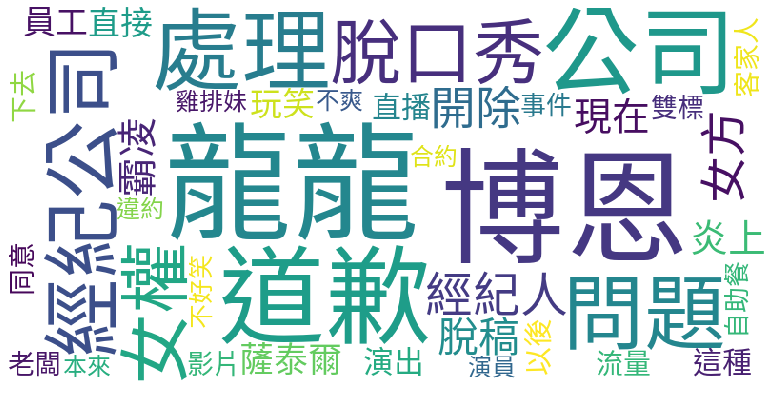

In [34]:
dict_1002 = Wc_dict(word_count,"2021-10-2",450,10)

font = './SourceHanSansTW-Regular.otf' #中文字型路徑
wordcloud = WordCloud(background_color='white',width=800, height = 400, font_path=font, colormap='viridis')
wordcloud.generate_from_frequencies(dict_1002)
plt.figure(figsize = (14,7))
plt.imshow(wordcloud)
plt.axis("off") #把作圖的座標軸關掉 
plt.show()

In [52]:
sentiment_sum = data_jealous0953.groupby(['word','sentiments']).size().reset_index(name='counts')
sentiment_sum = sentiment_sum.sort_values(by=['counts'], ascending=False)  #排序
sentiment_sum.head()

word sentiments  counts
69    問題   negative      84
248   道歉   negative      73
257   開除   negative      31
265   雙標   negative      28
195   白癡   negative      24

<BarContainer object of 15 artists>

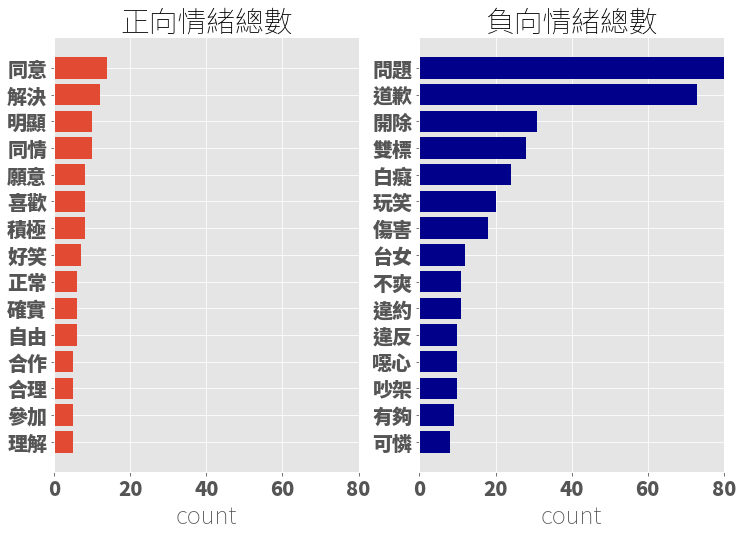

In [53]:
p_sum = sentiment_sum[sentiment_sum["sentiments"]=="positive"].head(15).sort_values(by=['counts'])
n_sum = sentiment_sum[sentiment_sum["sentiments"]=="negative"].head(15).sort_values(by=['counts'])

plt.figure(figsize=(12,8))   # 顯示圖框架大小 (寬,高)
plt.style.use("ggplot")     # 使用ggplot主題樣式
plt.rcParams['font.sans-serif']=['Noto Sans TC'] #使中文能正常顯示
plt.rcParams["font.size"] = 20
plt.rcParams["font.weight"] = 'black'

plt.subplot(121)
plt.title('正向情緒總數')
plt.xlabel('count')
plt.xlim(0,80)
plt.barh(p_sum['word'],p_sum['counts'])

plt.subplot(122)
plt.title('負向情緒總數')
plt.xlabel('count')
plt.xlim(0,80)
plt.barh(n_sum['word'],n_sum['counts'],color="darkblue")



#### 分析用戶 punk70286

In [54]:
data_punk70286 = data_liwc.loc[data_liwc['artPoster']=='punk70286']
word_count = data_punk70286.groupby(['artDate','word']).size().reset_index(name='counts')
word_count.sort_values(by='counts',ascending=False,inplace=True)  #排序
word_count = word_count.loc[word_count['counts']>3]  #過濾出現太少次的字
word_count.head(10)

artDate word  counts
299  2021-10-02   台女     136
1448 2021-10-02   道歉     106
1612 2021-10-02   龍龍      85
919  2021-10-02   活該      60
199  2021-10-02   公司      59
363  2021-10-02   噁心      56
253  2021-10-02   博恩      54
294  2021-10-02   可怕      52
344  2021-10-02   問題      44
1205 2021-10-02  脫口秀      41

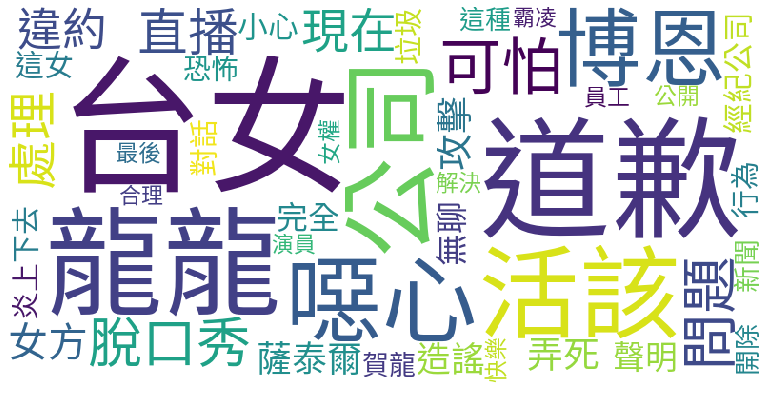

In [55]:
dict_1002 = Wc_dict(word_count,"2021-10-2",450,10)

font = './SourceHanSansTW-Regular.otf' #中文字型路徑
wordcloud = WordCloud(background_color='white',width=800, height = 400, font_path=font, colormap='viridis')
wordcloud.generate_from_frequencies(dict_1002)
plt.figure(figsize = (14,7))
plt.imshow(wordcloud)
plt.axis("off") #把作圖的座標軸關掉 
plt.show()

In [56]:
sentiment_sum = data_punk70286.groupby(['word','sentiments']).size().reset_index(name='counts')
sentiment_sum = sentiment_sum.sort_values(by=['counts'], ascending=False)  #排序
sentiment_sum.head()

word sentiments  counts
59    台女   negative     136
275   道歉   negative     106
187   活該   negative      60
71    噁心   negative      56
55    可怕   negative      52

<BarContainer object of 15 artists>

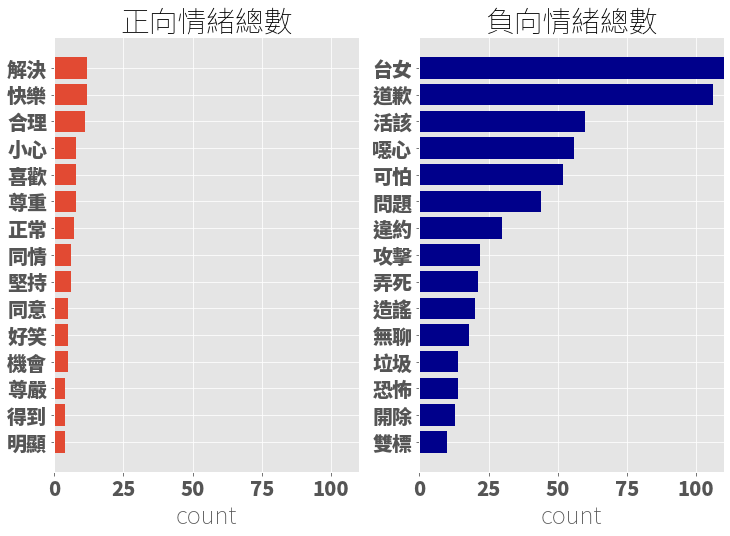

In [57]:
p_sum = sentiment_sum[sentiment_sum["sentiments"]=="positive"].head(15).sort_values(by=['counts'])
n_sum = sentiment_sum[sentiment_sum["sentiments"]=="negative"].head(15).sort_values(by=['counts'])

plt.figure(figsize=(12,8))   # 顯示圖框架大小 (寬,高)
plt.style.use("ggplot")     # 使用ggplot主題樣式
plt.rcParams['font.sans-serif']=['Noto Sans TC'] #使中文能正常顯示
plt.rcParams["font.size"] = 20
plt.rcParams["font.weight"] = 'black'

plt.subplot(121)
plt.title('正向情緒總數')
plt.xlabel('count')
plt.xlim(0,110)
plt.barh(p_sum['word'],p_sum['counts'])

plt.subplot(122)
plt.title('負向情緒總數')
plt.xlabel('count')
plt.xlim(0,110)
plt.barh(n_sum['word'],n_sum['counts'],color="darkblue")


#\plt.show()

### 10/3 事件:龍龍抓小辮子繼續開火,  分析用戶: error123, takizawa5566

#### 分析用戶 error123

In [58]:
data_error123 = data_liwc.loc[data_liwc['artPoster']=='error123']
word_count = data_error123.groupby(['artDate','word']).size().reset_index(name='counts')
word_count.sort_values(by='counts',ascending=False,inplace=True)  #排序
word_count = word_count.loc[word_count['counts']>3]  #過濾出現太少次的字
word_count.head(10)

artDate word  counts
707  2021-10-03   帳號     195
467  2021-10-03   噁心     194
1828 2021-10-03   雙標     150
1465 2021-10-03  自助餐      86
375  2021-10-03   台女      70
1829 2021-10-03  雙標仔      68
519  2021-10-03  塔綠班      53
583  2021-10-03   女權      46
374  2021-10-03   可憐      40
329  2021-10-03   博恩      33

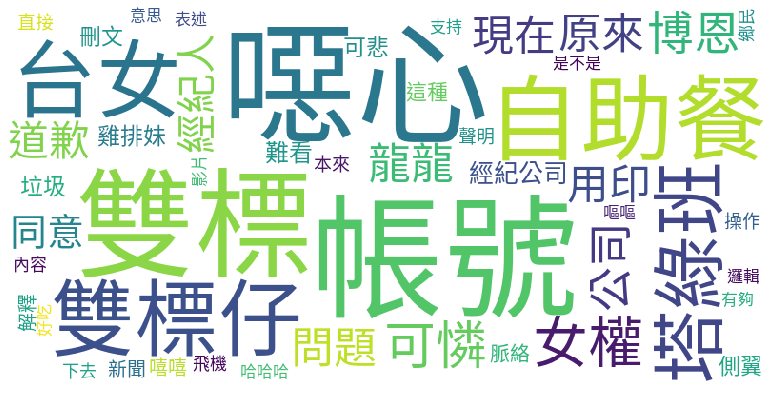

In [59]:
dict_1003 = Wc_dict(word_count,"2021-10-3",450,10)

font = './SourceHanSansTW-Regular.otf' #中文字型路徑
wordcloud = WordCloud(background_color='white',width=800, height = 400, font_path=font, colormap='viridis')
wordcloud.generate_from_frequencies(dict_1003)
plt.figure(figsize = (14,7))
plt.imshow(wordcloud)
plt.axis("off") #把作圖的座標軸關掉 
plt.show()

In [60]:
sentiment_sum = data_error123.groupby(['word','sentiments']).size().reset_index(name='counts')
sentiment_sum = sentiment_sum.sort_values(by=['counts'], ascending=False)  #排序
sentiment_sum.head()

word sentiments  counts
70    噁心   negative     194
286   雙標   negative     150
55    台女   negative      70
287  雙標仔   negative      68
54    可憐   negative      40

<BarContainer object of 15 artists>

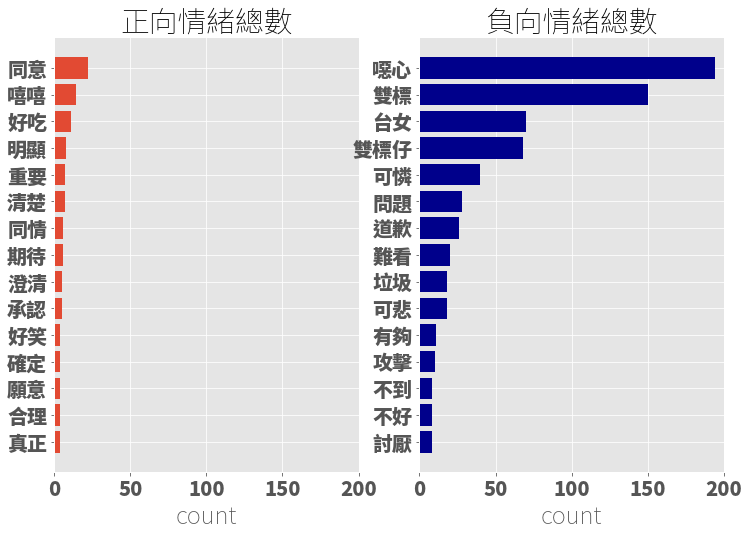

In [61]:
p_sum = sentiment_sum[sentiment_sum["sentiments"]=="positive"].head(15).sort_values(by=['counts'])
n_sum = sentiment_sum[sentiment_sum["sentiments"]=="negative"].head(15).sort_values(by=['counts'])

plt.figure(figsize=(12,8))   # 顯示圖框架大小 (寬,高)
plt.style.use("ggplot")     # 使用ggplot主題樣式
plt.rcParams['font.sans-serif']=['Noto Sans TC'] #使中文能正常顯示
plt.rcParams["font.size"] = 20
plt.rcParams["font.weight"] = 'black'

plt.subplot(121)
plt.title('正向情緒總數')
plt.xlabel('count')
plt.xlim(0,200)
plt.barh(p_sum['word'],p_sum['counts'])

plt.subplot(122)
plt.title('負向情緒總數')
plt.xlabel('count')
plt.xlim(0,200)
plt.barh(n_sum['word'],n_sum['counts'],color="darkblue")


#\plt.show()

#### 分析用戶 takizawa5566

In [62]:
data_takizawa5566 = data_liwc.loc[data_liwc['artPoster']=='takizawa5566']
word_count = data_takizawa5566.groupby(['artDate','word']).size().reset_index(name='counts')
word_count.sort_values(by='counts',ascending=False,inplace=True)  #排序
word_count = word_count.loc[word_count['counts']>3]  #過濾出現太少次的字
word_count.head(10)

artDate word  counts
257  2021-10-03   噁心     132
1030 2021-10-03   雙標     102
1045 2021-10-03   霸凌      88
749  2021-10-03   私訊      60
196  2021-10-03   可怕      44
128  2021-10-03   公審      37
133  2021-10-03   公開      36
200  2021-10-03   台女      32
917  2021-10-03   路人      31
1031 2021-10-03  雙標仔      28

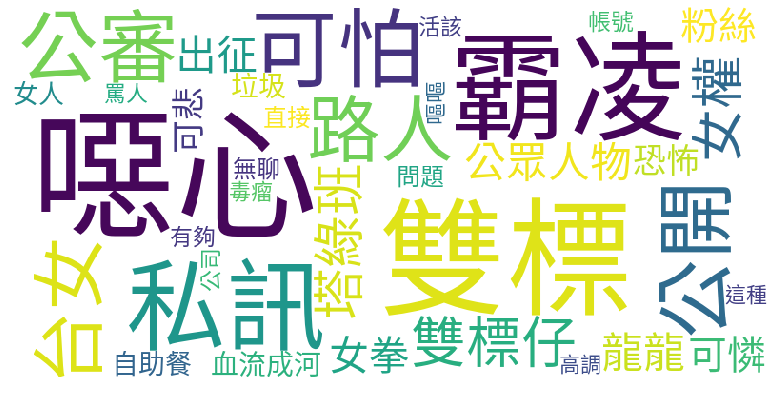

In [63]:
dict_1003 = Wc_dict(word_count,"2021-10-3",450,10)

font = './SourceHanSansTW-Regular.otf' #中文字型路徑
wordcloud = WordCloud(background_color='white',width=800, height = 400, font_path=font, colormap='viridis')
wordcloud.generate_from_frequencies(dict_1003)
plt.figure(figsize = (14,7))
plt.imshow(wordcloud)
plt.axis("off") #把作圖的座標軸關掉 
plt.show()

In [64]:
sentiment_sum = data_takizawa5566.groupby(['word','sentiments']).size().reset_index(name='counts')
sentiment_sum = sentiment_sum.sort_values(by=['counts'], ascending=False)  #排序
sentiment_sum.head()

word sentiments  counts
47    噁心   negative     132
181   雙標   negative     102
31    可怕   negative      44
34    台女   negative      32
182  雙標仔   negative      28

<BarContainer object of 15 artists>

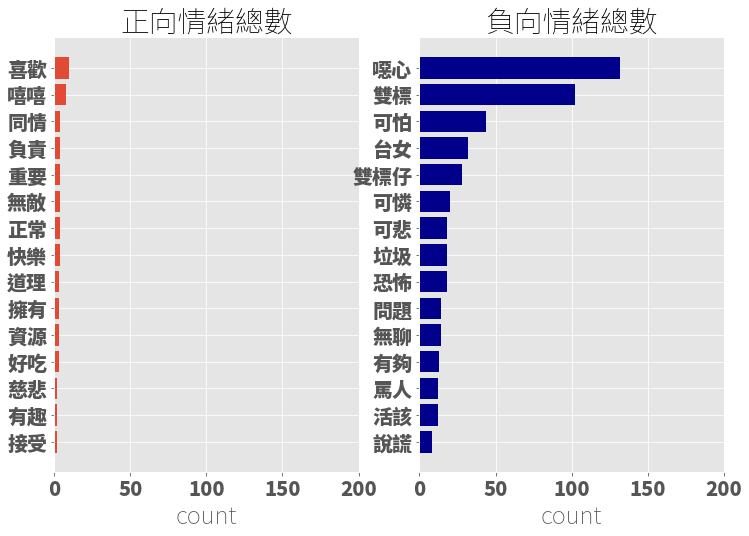

In [65]:
p_sum = sentiment_sum[sentiment_sum["sentiments"]=="positive"].head(15).sort_values(by=['counts'])
n_sum = sentiment_sum[sentiment_sum["sentiments"]=="negative"].head(15).sort_values(by=['counts'])

plt.figure(figsize=(12,8))   # 顯示圖框架大小 (寬,高)
plt.style.use("ggplot")     # 使用ggplot主題樣式
plt.rcParams['font.sans-serif']=['Noto Sans TC'] #使中文能正常顯示
plt.rcParams["font.size"] = 20
plt.rcParams["font.weight"] = 'black'

plt.subplot(121)
plt.title('正向情緒總數')
plt.xlabel('count')
plt.xlim(0,200)
plt.barh(p_sum['word'],p_sum['counts'])

plt.subplot(122)
plt.title('負向情緒總數')
plt.xlabel('count')
plt.xlim(0,200)
plt.barh(n_sum['word'],n_sum['counts'],color="darkblue")


#\plt.show()

 ### 10/6 事件: 龍龍釋出 11 分鐘淚崩影片, 分析用戶: ororzzz

In [66]:
data_ororzzz = data_liwc.loc[data_liwc['artPoster']=='ororzzz']
word_count = data_ororzzz.groupby(['artDate','word']).size().reset_index(name='counts')
word_count.sort_values(by='counts',ascending=False,inplace=True)  #排序
word_count = word_count.loc[word_count['counts']>3]  #過濾出現太少次的字
word_count.head(10)

artDate word  counts
1280 2021-10-06   雙標     132
1199 2021-10-06   道歉      96
348  2021-10-06   噁心      90
1281 2021-10-06  雙標仔      52
279  2021-10-06   台女      50
843  2021-10-06   無聊      36
679  2021-10-06   新聞      30
445  2021-10-06  客家人      28
237  2021-10-06   博恩      26
1297 2021-10-06   霸凌      25

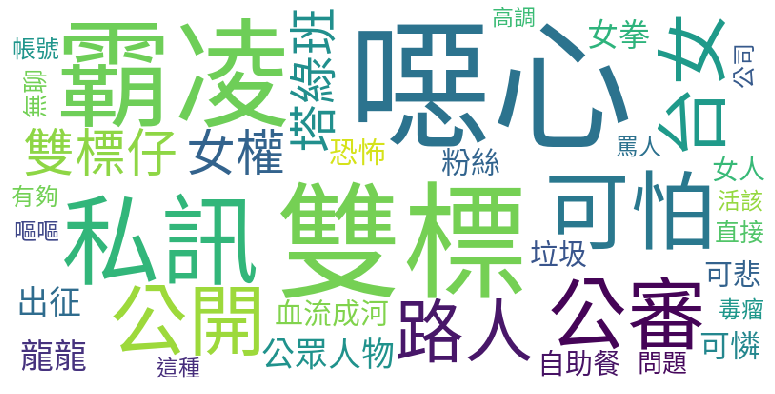

In [67]:
dict_1006 = Wc_dict(word_count,"2021-10-6",450,10)

font = './SourceHanSansTW-Regular.otf' #中文字型路徑
wordcloud = WordCloud(background_color='white',width=800, height = 400, font_path=font, colormap='viridis')
wordcloud.generate_from_frequencies(dict_1003)
plt.figure(figsize = (14,7))
plt.imshow(wordcloud)
plt.axis("off") #把作圖的座標軸關掉 
plt.show()

In [68]:
sentiment_sum = data_takizawa5566.groupby(['word','sentiments']).size().reset_index(name='counts')
sentiment_sum = sentiment_sum.sort_values(by=['counts'], ascending=False)  #排序
sentiment_sum.head()

word sentiments  counts
47    噁心   negative     132
181   雙標   negative     102
31    可怕   negative      44
34    台女   negative      32
182  雙標仔   negative      28

<BarContainer object of 15 artists>

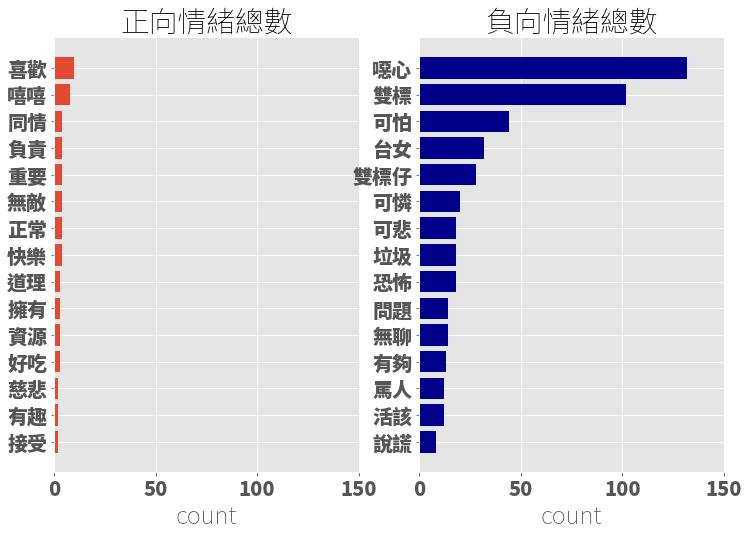

In [69]:
p_sum = sentiment_sum[sentiment_sum["sentiments"]=="positive"].head(15).sort_values(by=['counts'])
n_sum = sentiment_sum[sentiment_sum["sentiments"]=="negative"].head(15).sort_values(by=['counts'])

plt.figure(figsize=(12,8))   # 顯示圖框架大小 (寬,高)
plt.style.use("ggplot")     # 使用ggplot主題樣式
plt.rcParams['font.sans-serif']=['Noto Sans TC'] #使中文能正常顯示
plt.rcParams["font.size"] = 20
plt.rcParams["font.weight"] = 'black'

plt.subplot(121)
plt.title('正向情緒總數')
plt.xlabel('count')
plt.xlim(0,150)
plt.barh(p_sum['word'],p_sum['counts'])

plt.subplot(122)
plt.title('負向情緒總數')
plt.xlabel('count')
plt.xlim(0,150)
plt.barh(n_sum['word'],n_sum['counts'],color="darkblue")


#\plt.show()

# 總結

#### 從這篇分析中可以看出公眾人物的言行會直接反應在社群平台的「討論度」以及「風向」，此外還可以感覺到大多網友都只是看個熱鬧，「八卦」詞彙幾乎每天都會高頻率出現，雞排妹的屠龍行為，或許也是在感受到網路上幾日的逆風氛圍才考慮進行切割的。